In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import discovery as ds
import json
import numpy as np
import jax.numpy as jnp
import glob
import matplotlib.pyplot as plt
import jax
jax.config.update('jax_enable_x64', True)
import argparse
from functools import partial
import json
import discovery.samplers.numpyro as ds_numpyro
from pathlib import Path
import pickle
import corner
import inspect
import typing
import copy
import random

In [294]:
feather_dir = "./from_polina/"

In [295]:
psrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob(feather_dir+'*.feather'))][:20] #For now just grabbing 20 psrs

## Psr signal injection as follows:
- gwtheta=1.0471975511965979
- gwphi=3.141592653589793
- dist=69.75
- log10_mc=9
- fgw=2e-08
- inc=0
- rzn=0
- curn

### Truth values of the pulsar distances are contained in psr.pdist

The contention is that the hessian of the lnL should be greatly maximised where the psr distance search values are at the true values

### Set up signal model below:

In [296]:
# Custom function to use the p_dist rather than p_phase


def fpc_fast(pos, gwtheta, gwphi):
    x, y, z = pos

    sin_phi = jnp.sin(gwphi)
    cos_phi = jnp.cos(gwphi)
    sin_theta = jnp.sin(gwtheta)
    cos_theta = jnp.cos(gwtheta)

    m_dot_pos = sin_phi * x - cos_phi * y
    n_dot_pos = -cos_theta * cos_phi * x - cos_theta * sin_phi * y + sin_theta * z
    omhat_dot_pos = -sin_theta * cos_phi * x - sin_theta * sin_phi * y - cos_theta * z

    denom = 1.0 + omhat_dot_pos

    fplus = 0.5 * (m_dot_pos**2 - n_dot_pos**2) / denom
    fcross = (m_dot_pos * n_dot_pos) / denom

    return fplus, fcross
    
def cos2comp(f, df, A, f0, phi, t0):
    """Project signal A * cos(2pi f t + phi) onto Fourier basis
    cos(2pi k t/T), sin(2pi k t/T) for t in [t0, t0+T]."""

    T = 1.0 / df[0]

    Delta_omega = 2.0 * jnp.pi * (f0 - f[::2])
    Sigma_omega = 2.0 * jnp.pi * (f0 + f[::2])

    phase_Delta_start = phi + Delta_omega * t0
    phase_Delta_end   = phi + Delta_omega * (t0 + T)

    phase_Sigma_start = phi + Sigma_omega * t0
    phase_Sigma_end   = phi + Sigma_omega * (t0 + T)

    ck = (A / T) * (
        (jnp.sin(phase_Delta_end) - jnp.sin(phase_Delta_start)) / Delta_omega +
        (jnp.sin(phase_Sigma_end) - jnp.sin(phase_Sigma_start)) / Sigma_omega
    )

    sk = (A / T) * (
        (jnp.cos(phase_Delta_end) - jnp.cos(phase_Delta_start)) / Delta_omega -
        (jnp.cos(phase_Sigma_end) - jnp.cos(phase_Sigma_start)) / Sigma_omega
    )

    return jnp.stack((sk, ck), axis=1).reshape(-1)



def makefourier_binary_pdist(pulsarterm=True):
    def fourier_binary_pdist(f, df, mintoa, pos, log10_h0, log10_f0, ra, sindec, cosinc, psi, phi_earth, p_dist):
        h0 = 10**log10_h0
        f0 = 10**log10_f0

        pos = jnp.array(pos)
        
        dec, inc = jnp.arcsin(sindec), jnp.arccos(cosinc)

        # calculate antenna pattern
        fplus, fcross = fpc_fast(pos, 0.5 * jnp.pi - dec, ra)

        c = 2.99792458e8 
        omega_hat = jnp.array([ -jnp.cos(dec) * jnp.cos(ra), 
                                -jnp.cos(dec) * jnp.sin(ra),
                                -jnp.sin(dec)
                              ])

        # Convert pulsar distance from kpc to meters to match c [m/s]
        p_dist_m = p_dist * 3.0856775814913673e19  # 1 kpc in meters
        phi_psr = (p_dist_m / c) * 2.0 * jnp.pi * f0  * (1.0 + jnp.dot(omega_hat, pos))

        if pulsarterm:
            phi_avg = 0.5 * (phi_earth + phi_psr)
        else:
            phi_avg = phi_earth

        tref = 86400.0 * 51544.5  # MJD J2000 in seconds

        cphase = cos2comp(f, df, 1.0, f0, phi_avg - 2.0 * jnp.pi * f0 * tref, mintoa)
        sphase = cos2comp(f, df, 1.0, f0, phi_avg - 2.0 * jnp.pi * f0 * tref - 0.5 * jnp.pi, mintoa)

        if pulsarterm:
            phi_diff = 0.5 * (phi_earth - phi_psr)
            sin_diff = jnp.sin(phi_diff)

            delta_sin =  2.0 * cphase * sin_diff
            delta_cos = -2.0 * sphase * sin_diff
        else:
            delta_sin = sphase
            delta_cos = cphase

        At = -1.0 * (1.0 + jnp.cos(inc)**2) * delta_sin
        Bt =  2.0 * jnp.cos(inc) * delta_cos

        alpha = h0 / (2 * jnp.pi * f0)

        rplus  = alpha * (-At * jnp.cos(2 * psi) + Bt * jnp.sin(2 * psi))
        rcross = alpha * ( At * jnp.sin(2 * psi) + Bt * jnp.cos(2 * psi))

        res = -fplus * rplus - fcross * rcross

        return res

    if not pulsarterm:
        fourier_binary_pdist = functools.partial(fourier_binary, p_dist=jnp.nan)

    return fourier_binary_pdist

In [297]:
# Injected with effectively no WN

noisedict = {}
for psr in psrs:
    noisedict[psr.name+"_KAT_MKBF_efac"] = 1 # EFAC=1 means no EFAC
    noisedict[psr.name+"_KAT_MKBF_log10_ecorr"] = -8 # Bringing these down to effectively 0
    noisedict[psr.name+"_KAT_MKBF_log10_t2equad"] = -8

In [298]:
psr.residuals

array([ 2.45839919e-07, -1.20958816e-06,  2.17049564e-07, -1.39642583e-06,
       -2.31200856e-06, -5.93383739e-07,  1.19020773e-07,  2.71227718e-08,
       -8.84799112e-08, -1.45745027e-07, -8.35854432e-07, -9.69701339e-07,
       -1.10666605e-06,  7.98973950e-07, -1.23473994e-06, -4.22105587e-08,
       -2.33256642e-07, -1.38196610e-06, -1.21153815e-06,  6.79759827e-07,
        1.28289816e-06, -5.60252285e-07,  1.06598036e-06, -5.95541330e-07,
       -1.40923100e-06, -7.78890196e-07,  3.64435882e-07, -1.63412253e-06,
        2.04574507e-07,  4.67951452e-07, -5.90589764e-07,  1.68306427e-06,
        6.68520889e-07, -1.38649301e-07, -5.15705334e-07, -1.42969443e-06,
        3.48850509e-08,  4.18059725e-07,  1.88714263e-06,  5.48307745e-07,
        5.86910725e-07, -4.80621061e-07,  5.38547292e-07,  5.68146068e-07,
        6.70182682e-07,  1.18730780e-06, -9.60905620e-07, -9.42527221e-07,
        9.67034481e-07,  3.67233434e-07,  1.12897671e-06, -2.37314152e-06,
       -1.53995815e-07, -

In [299]:
for psr in psrs:
    wn_level = 1e-6
    psr.toaerrs = np.array(len(psr.toas) *[wn_level])

In [ ]:
# Fourier based CW delay
fourdelay = makefourier_binary_pdist(pulsarterm=True)
cwcommon = ['cw_sindec', 'cw_cosinc', 'cw_log10_f0', 'cw_log10_h0', 'cw_phi_earth', 'cw_psi', 'cw_ra']

T = ds.getspan(psrs)
fml = ds.GlobalLikelihood([ds.PulsarLikelihood([psr.residuals,
                                               ds.makenoise_measurement(psr, noisedict=noisedict),
                                               ds.makegp_timing(psr, variance=1e-14),
                                               ds.makegp_fourier(psr, ds.powerlaw, 30, T=ds.getspan(psr), name='rednoise')
                                               ]) for psr in psrs],
                        #globalgp = ds.makegp_fourier_global(psrs, ds.powerlaw, ds.uncorrelated_orf, 14, T=T, means = fourdelay, common = ['crn_gamma', 'crn_log10_A'] +cwcommon, name='crn', meansname='cw'))
                        globalgp = ds.makecommongp_fourier(psrs, ds.powerlaw, 30, T, means=fourdelay, common=['crn_gamma', 'crn_log10_A'] + cwcommon, name='rednoise', meansname='cw'))
                        #globalgp = ds.makegp_fourier_global(psrs, ds.powerlaw, ds.hd_orf, 14, T=T, means=fourdelay, common=cwcommon, name='gw', meansname='cw'))

In [323]:
# # Fourier based CW delay
# fourdelay = makefourier_binary_pdist(pulsarterm=True)
# cwcommon = ['cw_sindec', 'cw_cosinc', 'cw_log10_f0', 'cw_log10_h0', 'cw_phi_earth', 'cw_psi', 'cw_ra']

# T = ds.getspan(psrs)
# fml = ds.GlobalLikelihood([ds.PulsarLikelihood([psr.residuals,
#                                                ds.makenoise_measurement(psr, noisedict=noisedict),
#                                                ds.makegp_timing(psr, variance=1e-14),
#                                                ds.makegp_fourier(psr, ds.powerlaw, 30, T=ds.getspan(psr), name='rednoise')
#                                                ]) for psr in psrs],
#                         globalgp = ds.makegp_fourier_global(psrs, ds.powerlaw, ds.uncorrelated_orf, 14, T=T, common = ['crn_gamma', 'crn_log10_A'], name='crn'))

In [324]:
psr.residuals

array([-1.79782655e-06, -8.63565536e-07,  8.23891557e-07,  3.61905730e-07,
       -5.98005353e-07, -1.12267409e-06,  1.65003411e-06,  5.36226634e-07,
        3.89700261e-07,  8.98677460e-07, -2.67588645e-07,  3.08245374e-07,
       -5.80478985e-07, -4.00910599e-07,  1.28534167e-07, -1.05394370e-06,
       -8.47202913e-08, -1.13815508e-06,  8.56567509e-07, -5.58424303e-07,
       -4.28487391e-07,  1.44591968e-07, -1.27041749e-06,  9.13178726e-07,
       -1.74529515e-06, -1.09754402e-06, -6.53473812e-07, -6.41479644e-07,
       -7.34552261e-07, -1.44383836e-06,  7.54561482e-07, -1.18180813e-06,
        1.46972292e-06,  1.20686577e-06, -4.23290439e-07,  1.79472430e-06,
        1.21538273e-06, -1.24265517e-07, -3.58520662e-08,  1.13929880e-06,
       -1.25332875e-06,  1.77998020e-07,  5.94633314e-07,  1.23716571e-06,
        2.42432484e-06,  6.31516883e-07,  3.81122842e-08,  2.45712221e-07,
        1.11423780e-06,  8.99618458e-07, -1.08078592e-06,  1.76561038e-06,
       -1.02402366e-06,  

In [325]:
ds.prior.priordict_standard

{'(.*_)?efac': [0.9, 1.1],
 '(.*_)?t2equad': [-8.5, -5],
 '(.*_)?tnequad': [-8.5, -5],
 '(.*_)?log10_ecorr': [-8.5, -5],
 '(.*_)?rednoise_log10_A.*': [-20, -11],
 '(.*_)?rednoise_gamma.*': [0, 7],
 '(.*_)?rednoise_log10_fb': [-9, -6],
 '(.*_)?red_noise_log10_A.*': [-20, -11],
 '(.*_)?red_noise_gamma.*': [0, 7],
 '(.*_)?red_noise_log10_fb': [-9, -6],
 'crn_log10_A.*': [-18, -11],
 'crn_gamma.*': [0, 7],
 'crn_log10_fb': [-9, -6],
 'gw_(.*_)?log10_A': [-18, -11],
 'gw_(.*_)?gamma': [0, 7],
 'gw_log10_fb': [-9, -6],
 '(.*_)?dmgp_log10_A': [-20, -11],
 '(.*_)?dmgp_gamma': [0, 7],
 '(.*_)?dmgp_alpha': [1, 3],
 '(.*_)?chromgp_log10_A': [-20, -11],
 '(.*_)?chromgp_gamma': [0, 7],
 '(.*_)?chromgp_alpha': [1, 7],
 '(.*_)?dm_gp_log10_A': [-20, -11],
 '(.*_)?dm_gp_gamma': [0, 7],
 '(.*_)?dm_gp_alpha': [1, 3],
 '(.*_)?chrom_gp_log10_A': [-20, -11],
 '(.*_)?chrom_gp_gamma': [0, 7],
 '(.*_)?chrom_gp_alpha': [1, 3],
 'crn_log10_rho': [-9, -4],
 'gw_(.*_)?log10_rho': [-9, -4],
 '(.*_)?red_noise_log10_

In [326]:
ds.prior.priordict_standard.update({
    '(.*_)?cw_p_dist':     [0.1, 10]
})

In [327]:
for psr in psrs:
    print(psr.pdist)

[1.18, 0.12]
[3.1, 0.2]
[4.64, 0.93]
[1.02, 0.11]
[0.3296, 0.0036]
[0.873, 0.1746]
[1.71, 0.34]
[1.72, 0.34]
[0.1549, 0.001]
[1.45, 0.29]
[2.87, 0.57]
[0.7, 0.14]
[1.38, 0.14]
[1.07, 0.1]
[0.63, 0.126]
[1.27, 0.29]
[0.679, 0.1358]
[1.37, 0.19]
[1.8, 0.36]
[0.106, 0.0212]


In [328]:
psr.residuals

array([-1.79782655e-06, -8.63565536e-07,  8.23891557e-07,  3.61905730e-07,
       -5.98005353e-07, -1.12267409e-06,  1.65003411e-06,  5.36226634e-07,
        3.89700261e-07,  8.98677460e-07, -2.67588645e-07,  3.08245374e-07,
       -5.80478985e-07, -4.00910599e-07,  1.28534167e-07, -1.05394370e-06,
       -8.47202913e-08, -1.13815508e-06,  8.56567509e-07, -5.58424303e-07,
       -4.28487391e-07,  1.44591968e-07, -1.27041749e-06,  9.13178726e-07,
       -1.74529515e-06, -1.09754402e-06, -6.53473812e-07, -6.41479644e-07,
       -7.34552261e-07, -1.44383836e-06,  7.54561482e-07, -1.18180813e-06,
        1.46972292e-06,  1.20686577e-06, -4.23290439e-07,  1.79472430e-06,
        1.21538273e-06, -1.24265517e-07, -3.58520662e-08,  1.13929880e-06,
       -1.25332875e-06,  1.77998020e-07,  5.94633314e-07,  1.23716571e-06,
        2.42432484e-06,  6.31516883e-07,  3.81122842e-08,  2.45712221e-07,
        1.11423780e-06,  8.99618458e-07, -1.08078592e-06,  1.76561038e-06,
       -1.02402366e-06,  

In [329]:
fml.logL.params

AttributeError: 'VariableGP' object has no attribute 'Phi_inv'

In [308]:
sampler = fml.sample

In [309]:
noisedict_red = {}

noisedict_red.update({p: np.random.uniform(-18,-17) for p in fml.logL.params if 'rednoise_log10_A' in p})
noisedict_red.update({p: np.random.uniform(1,7) for p in fml.logL.params if 'rednoise_gamma' in p})


In [310]:
for psr in psrs:
    noisedict_red.update({p: psr.pdist[0] for p in fml.logL.params if psr.name+'_cw_p_dist' in p})

In [311]:
noisedict_red

{'B1855+09_rednoise_log10_A': -17.364225947830995,
 'B1937+21_rednoise_log10_A': -17.18013726788628,
 'B1953+29_rednoise_log10_A': -17.19826413934172,
 'J0023+0923_rednoise_log10_A': -17.265693892346658,
 'J0030+0451_rednoise_log10_A': -17.453296770826945,
 'J0125-2327_rednoise_log10_A': -17.899608907884893,
 'J0340+4130_rednoise_log10_A': -17.677112193457518,
 'J0406+3039_rednoise_log10_A': -17.809640154008882,
 'J0437-4715_rednoise_log10_A': -17.886556425048138,
 'J0509+0856_rednoise_log10_A': -17.341038180227002,
 'J0557+1551_rednoise_log10_A': -17.7134791716216,
 'J0605+3757_rednoise_log10_A': -17.987112873333786,
 'J0610-2100_rednoise_log10_A': -17.050671720927756,
 'J0613-0200_rednoise_log10_A': -17.6693355083476,
 'J0614-3329_rednoise_log10_A': -17.63276058645365,
 'J0636+5128_rednoise_log10_A': -17.837079965192757,
 'J0636-3044_rednoise_log10_A': -17.52369321376474,
 'J0645+5158_rednoise_log10_A': -17.559706438141227,
 'J0709+0458_rednoise_log10_A': -17.40118073591822,
 'J0711-

In [312]:
params = {**ds.sample_uniform(sampler.params), **noisedict_red}

In [313]:
params

{'B1855+09_rednoise_gamma': 1.6892080496987962,
 'B1855+09_rednoise_log10_A': -17.364225947830995,
 'B1937+21_rednoise_gamma': 2.477458818388272,
 'B1937+21_rednoise_log10_A': -17.18013726788628,
 'B1953+29_rednoise_gamma': 5.630438588704184,
 'B1953+29_rednoise_log10_A': -17.19826413934172,
 'J0023+0923_rednoise_gamma': 3.5270956668660283,
 'J0023+0923_rednoise_log10_A': -17.265693892346658,
 'J0030+0451_rednoise_gamma': 2.2858387295715348,
 'J0030+0451_rednoise_log10_A': -17.453296770826945,
 'J0125-2327_rednoise_gamma': 1.4639503216246275,
 'J0125-2327_rednoise_log10_A': -17.899608907884893,
 'J0340+4130_rednoise_gamma': 2.0298027710090043,
 'J0340+4130_rednoise_log10_A': -17.677112193457518,
 'J0406+3039_rednoise_gamma': 2.629309763375861,
 'J0406+3039_rednoise_log10_A': -17.809640154008882,
 'J0437-4715_rednoise_gamma': 4.06541442555537,
 'J0437-4715_rednoise_log10_A': -17.886556425048138,
 'J0509+0856_rednoise_gamma': 5.460761646441625,
 'J0509+0856_rednoise_log10_A': -17.3410381

In [314]:
params.update({'gw_gamma': 4.333, 'gw_log10_A': -14.5})
params.update({'cw_cosinc': 0, 'cw_log10_f0': -8, 'cw_log10_h0': -12, 'cw_phi_earth':np.pi, 'cw_psi': np.pi/4.0, 'cw_ra': 0.458, 'cw_sindec': 0.43})

In [315]:
params

{'B1855+09_rednoise_gamma': 1.6892080496987962,
 'B1855+09_rednoise_log10_A': -17.364225947830995,
 'B1937+21_rednoise_gamma': 2.477458818388272,
 'B1937+21_rednoise_log10_A': -17.18013726788628,
 'B1953+29_rednoise_gamma': 5.630438588704184,
 'B1953+29_rednoise_log10_A': -17.19826413934172,
 'J0023+0923_rednoise_gamma': 3.5270956668660283,
 'J0023+0923_rednoise_log10_A': -17.265693892346658,
 'J0030+0451_rednoise_gamma': 2.2858387295715348,
 'J0030+0451_rednoise_log10_A': -17.453296770826945,
 'J0125-2327_rednoise_gamma': 1.4639503216246275,
 'J0125-2327_rednoise_log10_A': -17.899608907884893,
 'J0340+4130_rednoise_gamma': 2.0298027710090043,
 'J0340+4130_rednoise_log10_A': -17.677112193457518,
 'J0406+3039_rednoise_gamma': 2.629309763375861,
 'J0406+3039_rednoise_log10_A': -17.809640154008882,
 'J0437-4715_rednoise_gamma': 4.06541442555537,
 'J0437-4715_rednoise_log10_A': -17.886556425048138,
 'J0509+0856_rednoise_gamma': 5.460761646441625,
 'J0509+0856_rednoise_log10_A': -17.3410381

In [316]:
# Creates psr residuals
key = ds.rngkey(43)
key, res = sampler(key, params)

In [317]:
sampler(key, params)

(Array([2601977107, 1848846142], dtype=uint32),
 [Array([-1.60515522e-06, -1.42935186e-06, -5.70692873e-07, -2.10874779e-06,
         -1.62525100e-06, -3.09438935e-06, -1.76727267e-06, -1.78426914e-07,
          8.01532545e-07, -2.48392287e-06, -2.13513388e-06, -1.24601920e-06,
         -2.74732485e-06, -1.70959862e-06, -1.17220886e-06, -2.76786463e-06,
         -2.17406539e-06, -1.27899591e-06,  2.62989883e-07, -1.03577941e-06,
         -3.97220489e-07, -2.14575257e-06,  7.92654344e-07, -2.64461217e-06,
         -1.17505816e-06, -2.27246841e-06, -2.06078963e-06,  8.93595290e-08,
          1.34631695e-07, -3.24216009e-07, -1.92919886e-06, -3.98738804e-07,
         -4.21881984e-07, -7.52602536e-07,  8.43837471e-08,  5.02700170e-07,
         -1.63592629e-06,  7.47678608e-08,  1.76572949e-06, -1.48862969e-06,
          5.49239752e-07, -5.40555668e-07,  2.46952540e-06, -2.84573493e-08,
          1.19268894e-06, -3.45058349e-07, -3.73072368e-07,  1.96331434e-06,
          1.59897772e-06,  1

In [318]:
res

[Array([-9.72392516e-07, -1.98016718e-06, -1.28087095e-06, -1.83601005e-06,
        -1.16496138e-06, -1.58152913e-06, -1.48030564e-06, -2.02919230e-06,
         1.76585947e-07, -2.39645171e-06, -2.25245196e-06, -2.44562694e-06,
        -1.83712662e-06, -1.85816577e-06,  8.22919054e-07, -9.46470868e-07,
        -6.62258688e-07, -4.28750985e-07, -2.26031312e-06,  7.46235005e-07,
         6.09945961e-07, -1.63007500e-06, -2.89199944e-08, -3.17625849e-06,
        -7.40681847e-07, -1.32653502e-06,  7.25649387e-07,  1.28648773e-06,
         1.83391597e-06,  9.99680901e-07,  2.33018658e-06,  5.58907525e-07,
         3.56428669e-07,  1.92048970e-06,  2.43551315e-06,  1.49931255e-06,
         2.32105079e-06,  1.45088947e-06,  9.68073961e-07,  2.48835373e-06,
         2.08227623e-06,  2.86570840e-06,  1.39299921e-06,  4.15848364e-08,
         8.18685852e-07,  9.47179139e-07,  1.86994030e-06,  2.63256437e-06,
         1.20796684e-06,  4.59306023e-07,  1.77229547e-06,  6.22127584e-07,
         1.8

In [319]:
p0 = ds.sample_uniform(fml.logL.params)


In [320]:
for i, psr in enumerate(psrs):
    psr.residuals = np.array(res[i])

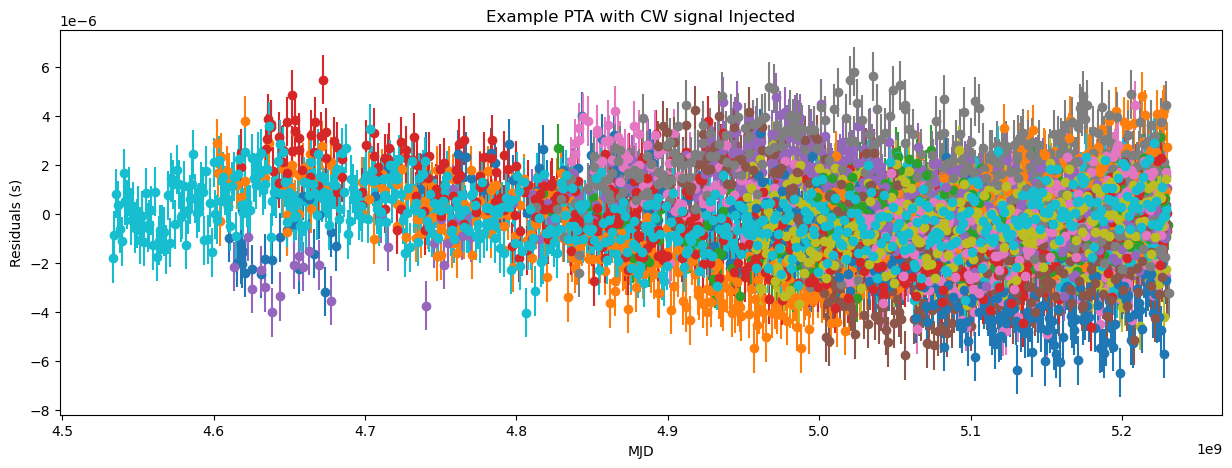

In [321]:
plt.figure(figsize=(15,5))
for psr in psrs:
    plt.errorbar(psr.toas, psr.residuals, yerr=psr.toaerrs, fmt='o')
    plt.xlabel('MJD')   
    plt.ylabel('Residuals (s)')
    plt.title("Example PTA with CW signal Injected")

In [181]:
len(psrs)

20

In [396]:
psr.residuals

array([-2.29554195e-07, -3.76104495e-07, -5.97041230e-07, -5.61090897e-07,
        6.92837908e-07, -4.50440215e-08, -5.31291525e-07, -4.55592167e-07,
        8.64968983e-07,  7.35829879e-07, -3.69703219e-07,  2.17880152e-07,
        7.33116484e-07,  4.80856613e-07, -1.52947641e-08, -6.56276161e-08,
       -1.08689866e-07, -4.41410120e-08, -4.32084658e-07,  3.15070065e-07,
       -4.62342466e-07,  2.74124635e-07, -1.33158233e-07,  1.01927321e-07,
       -8.72933606e-07,  9.62574198e-07,  1.28980157e-06,  5.84116386e-07,
       -1.06233330e-06,  1.39597633e-07,  4.53639188e-07, -1.13040624e-07,
        1.50434608e-07, -1.66122749e-07, -1.78346397e-07,  4.31051400e-07,
        7.77415086e-07, -2.05459411e-08, -9.67205947e-07, -7.36701226e-07,
       -3.62601845e-07,  1.65808455e-07, -3.09764950e-07, -7.77129958e-07,
       -1.12413642e-07, -4.20908773e-07, -7.13463792e-07, -7.41326180e-07,
        1.48993441e-07, -1.27553248e-07,  4.89522811e-08,  1.86522171e-06,
       -3.48916380e-07, -

In [397]:
# - gwtheta=1.0471975511965979
# - gwphi=3.141592653589793
# - dist=69.75
# - log10_mc=9
# - fgw=2e-08
# - inc=0
# - rzn=0
# - curn

In [398]:
logl = fml.logL

In [399]:
truths = {}
for psr in psrs:
    truths[psr.name+"_cw_p_dist"] = psr.pdist[0]

In [400]:
# Ignores uncertainty but the CW would be injected given the pdist value
truths

{'B1855+09_cw_p_dist': 1.18,
 'B1937+21_cw_p_dist': 3.1,
 'B1953+29_cw_p_dist': 4.64,
 'J0023+0923_cw_p_dist': 1.02,
 'J0030+0451_cw_p_dist': 0.3296,
 'J0125-2327_cw_p_dist': 0.873,
 'J0340+4130_cw_p_dist': 1.71,
 'J0406+3039_cw_p_dist': 1.72,
 'J0437-4715_cw_p_dist': 0.1549,
 'J0509+0856_cw_p_dist': 1.45}

In [401]:
for param in logl.params:
    if "rednoise_log10_A" in param:
        truths[param] = params[param]
    if "crn_log10_A" in param:
        truths[param] = params[param]
    if "rednoise_gamma" in param:
        truths[param] = params[param]
    if "crn_gamma" in param:
        truths[param] = params[param]
    if "cw_cosinc" in param:
        truths[param] = params[param]
    if "cw_log10_f0" in param:
        truths[param] = params[param]



In [402]:
touse = truths.copy()



gwtheta=1.0471975511965979
gwphi=3.141592653589793
dist=69.75
log10_mc=9
fgw=2e-08
inc=0
rzn=0
curn


In [403]:
ds.priordict_standard

{'(.*_)?efac': [0.9, 1.1],
 '(.*_)?t2equad': [-8.5, -5],
 '(.*_)?tnequad': [-8.5, -5],
 '(.*_)?log10_ecorr': [-8.5, -5],
 '(.*_)?rednoise_log10_A.*': [-20, -11],
 '(.*_)?rednoise_gamma.*': [0, 7],
 '(.*_)?rednoise_log10_fb': [-9, -6],
 '(.*_)?red_noise_log10_A.*': [-20, -11],
 '(.*_)?red_noise_gamma.*': [0, 7],
 '(.*_)?red_noise_log10_fb': [-9, -6],
 'crn_log10_A.*': [-18, -11],
 'crn_gamma.*': [0, 7],
 'crn_log10_fb': [-9, -6],
 'gw_(.*_)?log10_A': [-18, -11],
 'gw_(.*_)?gamma': [0, 7],
 'gw_log10_fb': [-9, -6],
 '(.*_)?dmgp_log10_A': [-20, -11],
 '(.*_)?dmgp_gamma': [0, 7],
 '(.*_)?dmgp_alpha': [1, 3],
 '(.*_)?chromgp_log10_A': [-20, -11],
 '(.*_)?chromgp_gamma': [0, 7],
 '(.*_)?chromgp_alpha': [1, 7],
 '(.*_)?dm_gp_log10_A': [-20, -11],
 '(.*_)?dm_gp_gamma': [0, 7],
 '(.*_)?dm_gp_alpha': [1, 3],
 '(.*_)?chrom_gp_log10_A': [-20, -11],
 '(.*_)?chrom_gp_gamma': [0, 7],
 '(.*_)?chrom_gp_alpha': [1, 3],
 'crn_log10_rho': [-9, -4],
 'gw_(.*_)?log10_rho': [-9, -4],
 '(.*_)?red_noise_log10_

In [404]:
params

{'B1855+09_rednoise_gamma': 5.6928003236689,
 'B1855+09_rednoise_log10_A': -15.74638709905823,
 'B1937+21_rednoise_gamma': 6.27631904896538,
 'B1937+21_rednoise_log10_A': -16.456813334929905,
 'B1953+29_rednoise_gamma': 6.4652333296061535,
 'B1953+29_rednoise_log10_A': -15.289954973597293,
 'J0023+0923_rednoise_gamma': 3.6935816655887486,
 'J0023+0923_rednoise_log10_A': -14.879828308217467,
 'J0030+0451_rednoise_gamma': 6.927107169541259,
 'J0030+0451_rednoise_log10_A': -16.253796482858704,
 'J0125-2327_rednoise_gamma': 6.7805512600615545,
 'J0125-2327_rednoise_log10_A': -15.32879290047281,
 'J0340+4130_rednoise_gamma': 6.008516248737078,
 'J0340+4130_rednoise_log10_A': -16.642367282151877,
 'J0406+3039_rednoise_gamma': 2.047523015983555,
 'J0406+3039_rednoise_log10_A': -17.121675545593707,
 'J0437-4715_rednoise_gamma': 3.2587838054646476,
 'J0437-4715_rednoise_log10_A': -14.109004396794184,
 'J0509+0856_rednoise_gamma': 6.9255739266514995,
 'J0509+0856_rednoise_log10_A': -16.776714886

In [405]:
# I think it's better not to have all the parameters correct, so these are incorrect. 
# I want to make sure that Hessian changes because of the pdists and not anything else

touse.update({'cw_log10_h0': params['cw_log10_h0'], 'cw_phi_earth': params['cw_phi_earth'], 'cw_psi': params['cw_psi'], 'cw_ra': params['cw_ra'], 'cw_sindec': params['cw_sindec'], 'cw_cosinc': params['cw_cosinc']}) 

In [406]:
order_map = {key: i for i, key in enumerate(logl.params)}

In [407]:
sorted_items = sorted(touse.items(), key=lambda item: order_map.get(item[0], float('inf')))

In [408]:
sorted_dict = dict(sorted_items)

In [409]:
sorted_dict

{'B1855+09_cw_p_dist': 1.18,
 'B1855+09_rednoise_gamma': 5.6928003236689,
 'B1855+09_rednoise_log10_A': -15.74638709905823,
 'B1937+21_cw_p_dist': 3.1,
 'B1937+21_rednoise_gamma': 6.27631904896538,
 'B1937+21_rednoise_log10_A': -16.456813334929905,
 'B1953+29_cw_p_dist': 4.64,
 'B1953+29_rednoise_gamma': 6.4652333296061535,
 'B1953+29_rednoise_log10_A': -15.289954973597293,
 'J0023+0923_cw_p_dist': 1.02,
 'J0023+0923_rednoise_gamma': 3.6935816655887486,
 'J0023+0923_rednoise_log10_A': -14.879828308217467,
 'J0030+0451_cw_p_dist': 0.3296,
 'J0030+0451_rednoise_gamma': 6.927107169541259,
 'J0030+0451_rednoise_log10_A': -16.253796482858704,
 'J0125-2327_cw_p_dist': 0.873,
 'J0125-2327_rednoise_gamma': 6.7805512600615545,
 'J0125-2327_rednoise_log10_A': -15.32879290047281,
 'J0340+4130_cw_p_dist': 1.71,
 'J0340+4130_rednoise_gamma': 6.008516248737078,
 'J0340+4130_rednoise_log10_A': -16.642367282151877,
 'J0406+3039_cw_p_dist': 1.72,
 'J0406+3039_rednoise_gamma': 2.047523015983555,
 'J0406

In [410]:
sorted_dict.values()

dict_values([1.18, 5.6928003236689, -15.74638709905823, 3.1, 6.27631904896538, -16.456813334929905, 4.64, 6.4652333296061535, -15.289954973597293, 1.02, 3.6935816655887486, -14.879828308217467, 0.3296, 6.927107169541259, -16.253796482858704, 0.873, 6.7805512600615545, -15.32879290047281, 1.71, 6.008516248737078, -16.642367282151877, 1.72, 2.047523015983555, -17.121675545593707, 0.1549, 3.2587838054646476, -14.109004396794184, 1.45, 6.9255739266514995, -16.776714886155442, 4.333, -17.5, 0, -8, -12.5, 3.141592653589793, 0.7853981633974483, 0.458, 0.43])

In [411]:
# Get the keys in the same order as values
param_keys = list(sorted_dict.keys())

# Define the wrapper
def logl_wrapped(x_array):
    # Convert array -> dict
    params = {k: v for k, v in zip(param_keys, x_array)}
    return logl(params)

In [412]:
#x0 = np.array(list(sorted_dict.values()), dtype=np.float64)
x0 = jnp.array(list(sorted_dict.values()), dtype=jnp.float64)
logl_fn = jax.jit(logl_wrapped)
grad_fn = jax.jit(jax.grad(logl_fn))
hess_fn = jax.jit(jax.hessian(logl_fn))

In [413]:
print("logl(x0) =", logl_wrapped(x0))

logl(x0) = -274165.02726586646


In [414]:
G = grad_fn(x0)

In [415]:
G

Array([-3.31924263e+06,  4.32524897e+01,  1.05916784e+02,  3.04076677e+08,
        1.04414488e+04,  2.73064400e+04,  6.02460833e+06,  3.05249895e+02,
        1.00698461e+03, -4.07343456e+07,  3.98214487e+04,  1.51973548e+05,
       -1.04656076e+08,  1.23790104e+04,  4.38950788e+04, -5.39643681e+05,
        6.75735364e+02,  2.52565651e+03,  6.21726253e+06,  1.37211182e+02,
        2.54627802e+02,  2.98519990e+06,  1.24890087e-03,  3.76598295e-03,
        1.44072529e+07,  1.19097511e+03,  5.12997227e+03,  8.83290031e+05,
        4.79962851e+00,  1.11364215e+01,  8.83981024e+00,  2.34498083e+01,
        1.11281716e+04,  2.09548675e+09, -1.41234820e+06,  1.27874963e+05,
       -3.33750187e+05,  6.63365949e+08, -6.97648411e+08], dtype=float64)

In [416]:
H = hess_fn(x0)

In [417]:
H.shape

(39, 39)

In [418]:
H

Array([[-1.34848623e+10,  5.29103839e+05,  1.30008111e+06, ...,
        -2.49828841e+07, -1.23609450e+10,  3.81588101e+09],
       [ 5.29103839e+05,  1.36254766e+01,  4.70039946e+01, ...,
         2.80604740e+02,  4.84770199e+05, -1.49839939e+05],
       [ 1.30008111e+06,  4.70039946e+01,  1.53741523e+02, ...,
         6.93058498e+02,  1.19114793e+06, -3.68176642e+05],
       ...,
       [-2.49828841e+07,  2.80604740e+02,  6.93058498e+02, ...,
         1.12287728e+06,  4.43496618e+09, -1.75436537e+09],
       [-1.23609450e+10,  4.84770199e+05,  1.19114793e+06, ...,
         4.43496618e+09,  1.12649102e+13, -5.45560524e+12],
       [ 3.81588101e+09, -1.49839939e+05, -3.68176642e+05, ...,
        -1.75436537e+09, -5.45560524e+12,  2.28509851e+12]],      dtype=float64)

In [422]:
sorted_dict

{'B1855+09_cw_p_dist': 1.18,
 'B1855+09_rednoise_gamma': 5.6928003236689,
 'B1855+09_rednoise_log10_A': -15.74638709905823,
 'B1937+21_cw_p_dist': 3.1,
 'B1937+21_rednoise_gamma': 6.27631904896538,
 'B1937+21_rednoise_log10_A': -16.456813334929905,
 'B1953+29_cw_p_dist': 4.64,
 'B1953+29_rednoise_gamma': 6.4652333296061535,
 'B1953+29_rednoise_log10_A': -15.289954973597293,
 'J0023+0923_cw_p_dist': 1.02,
 'J0023+0923_rednoise_gamma': 3.6935816655887486,
 'J0023+0923_rednoise_log10_A': -14.879828308217467,
 'J0030+0451_cw_p_dist': 0.3296,
 'J0030+0451_rednoise_gamma': 6.927107169541259,
 'J0030+0451_rednoise_log10_A': -16.253796482858704,
 'J0125-2327_cw_p_dist': 0.873,
 'J0125-2327_rednoise_gamma': 6.7805512600615545,
 'J0125-2327_rednoise_log10_A': -15.32879290047281,
 'J0340+4130_cw_p_dist': 1.71,
 'J0340+4130_rednoise_gamma': 6.008516248737078,
 'J0340+4130_rednoise_log10_A': -16.642367282151877,
 'J0406+3039_cw_p_dist': 1.72,
 'J0406+3039_rednoise_gamma': 2.047523015983555,
 'J0406

In [423]:
unc = jnp.sqrt(jnp.abs(jnp.diagonal(jnp.linalg.inv(-H))))

In [424]:
jnp.sum(unc)

Array(134.89472139, dtype=float64)

In [425]:
jnp.diagonal(jnp.linalg.inv(-H))

Array([ 1.33493419e-09,  1.66315368e+01,  2.03139065e+00,  8.59200110e-09,
        1.87770133e-04, -5.98190164e-05,  2.15213620e-08,  4.64068031e-02,
        5.47184837e-04, -1.59805117e-08, -4.92875621e-02, -3.40173876e-03,
       -1.64860087e-09, -9.14339026e-03, -6.82793521e-04, -1.42516940e-09,
       -1.61933725e-01, -1.23532776e-02, -2.02110038e-08, -4.44444868e-01,
       -1.27718869e-01,  7.81450543e-09, -8.02802526e+03, -9.40550060e+02,
        4.89569334e-11,  8.83461303e-02,  4.12003420e-03,  1.87189177e-08,
       -1.59087817e+01, -2.95846405e+00, -3.62550185e-01, -6.07637829e-02,
        3.19334127e-07,  2.96697615e-10, -6.09454645e-08, -4.63658387e-06,
       -1.39988396e-06,  2.89809311e-10, -4.85497547e-10], dtype=float64)

In [426]:
val = logl_wrapped(x0)
print(val)

-274165.02726586646


In [427]:
jax.debug.print("params: {}", x0)

params: [  1.18         5.69280032 -15.7463871    3.1          6.27631905
 -16.45681333   4.64         6.46523333 -15.28995497   1.02
   3.69358167 -14.87982831   0.3296       6.92710717 -16.25379648
   0.873        6.78055126 -15.3287929    1.71         6.00851625
 -16.64236728   1.72         2.04752302 -17.12167555   0.1549
   3.25878381 -14.1090044    1.45         6.92557393 -16.77671489
   4.333      -17.5          0.          -8.         -12.5
   3.14159265   0.78539816   0.458        0.43      ]


In [428]:
touse

{'B1855+09_cw_p_dist': 1.18,
 'B1937+21_cw_p_dist': 3.1,
 'B1953+29_cw_p_dist': 4.64,
 'J0023+0923_cw_p_dist': 1.02,
 'J0030+0451_cw_p_dist': 0.3296,
 'J0125-2327_cw_p_dist': 0.873,
 'J0340+4130_cw_p_dist': 1.71,
 'J0406+3039_cw_p_dist': 1.72,
 'J0437-4715_cw_p_dist': 0.1549,
 'J0509+0856_cw_p_dist': 1.45,
 'B1855+09_rednoise_gamma': 5.6928003236689,
 'B1855+09_rednoise_log10_A': -15.74638709905823,
 'B1937+21_rednoise_gamma': 6.27631904896538,
 'B1937+21_rednoise_log10_A': -16.456813334929905,
 'B1953+29_rednoise_gamma': 6.4652333296061535,
 'B1953+29_rednoise_log10_A': -15.289954973597293,
 'J0023+0923_rednoise_gamma': 3.6935816655887486,
 'J0023+0923_rednoise_log10_A': -14.879828308217467,
 'J0030+0451_rednoise_gamma': 6.927107169541259,
 'J0030+0451_rednoise_log10_A': -16.253796482858704,
 'J0125-2327_rednoise_gamma': 6.7805512600615545,
 'J0125-2327_rednoise_log10_A': -15.32879290047281,
 'J0340+4130_rednoise_gamma': 6.008516248737078,
 'J0340+4130_rednoise_log10_A': -16.642367282

In [429]:
sindec = 0
dec = jnp.arcsin(sindec)
ra = 1.5707963267948966
omega_hat = jnp.array([ -jnp.cos(dec) * jnp.cos(ra), 
                        -jnp.cos(dec) * jnp.sin(ra),
                        -jnp.sin(dec)
                      ])

In [430]:
type(psrs[0].pos)

list

In [431]:
n_iters = 3
print(f"Overriding n_iters for smoke test: {n_iters}")

Overriding n_iters for smoke test: 3


In [432]:
try:
    _ = sorted_dict
    _ = param_keys
    _ = hess_fn
except NameError as e:
    raise RuntimeError("Required variables not found in this session: sorted_dict, param_keys, hess_fn") from e

base_dict = copy.deepcopy(sorted_dict)

In [433]:
cw_keys = [k for k in base_dict.keys() if 'cw_p_dist' in k]
if len(cw_keys) == 0:
    raise RuntimeError("No keys containing 'cw_p_dist' found in sorted_dict")

In [434]:
# Config
n_iters = 1000          # change to a smaller number for a quick smoke test
rng_seed = 12345        # set to None for non-deterministic

if rng_seed is not None:
    random.seed(rng_seed)

# Prepare baseline dict and target keys
base_dict = copy.deepcopy(sorted_dict)
cw_keys = [k for k in base_dict.keys() if 'cw_p_dist' in k]
if not cw_keys:
    raise RuntimeError("No keys containing 'cw_p_dist' found in sorted_dict")

# Output containers
results = {
    'cumulative_diffs': [],               # per-iteration sum over cw_p_dist keys of |new - original|
    'cumulative_diffs_running_total': [], # running total across iterations (optional convenience)
    'hessians': [],                       # np.array of Hessian matrices
    'perturbed_vectors': []               # np.array of full parameter vector (ordered by param_keys)
}

running_total = 0.0

# Single baseline test (no change)
d0 = base_dict.copy()
x0_vec = jnp.array([d0[k] for k in param_keys], dtype=jnp.float64)
H0 = hess_fn(x0_vec)
results['cumulative_diffs'].append(0.0)
results['cumulative_diffs_running_total'].append(running_total)
results['hessians'].append(np.array(H0))
results['perturbed_vectors'].append(np.array(x0_vec))

# Random perturbations
for i in range(n_iters):
    # Start from baseline values each iteration
    d = base_dict.copy()
    cumdiff = 0.0

    # Perturb each cw_p_dist key by a random ±(1%–90%)
    for k in cw_keys:
        orig = float(d[k])
        frac = random.uniform(1e-13, 0.90)
        sign = 1.0 if random.random() < 0.5 else -1.0
        new = orig * (1.0 + sign * frac)
        d[k] = new
        cumdiff += abs(new - orig)

    # Build full vector in the correct order
    x_vec = jnp.array([d[k] for k in param_keys], dtype=jnp.float64)

    # Evaluate Hessian and record (convert to NumPy for pickling)
    H = hess_fn(x_vec)
    H_np = np.array(H)

    running_total += float(cumdiff)
    results['cumulative_diffs'].append(float(cumdiff))
    results['cumulative_diffs_running_total'].append(running_total)
    results['hessians'].append(H_np)
    results['perturbed_vectors'].append(np.array(x_vec))

# Save results to disk
outpath = 'hessian_perturb_results.pkl'
with open(outpath, 'wb') as f:
    pickle.dump(results, f)

# Brief summary
n = len(results['hessians'])
mean_diff = float(np.mean(results['cumulative_diffs'])) if n else float('nan')
print(f"Completed {n} evaluations (including 1 baseline no-change + {n_iters} perturbations).")
print(f"Saved to: {outpath}")
print(f"Mean per-iteration cumulative |Δ(cw_p_dist)|: {mean_diff}")
if n:
    print("Example Hessian shape:", results['hessians'][0].shape)

Completed 1001 evaluations (including 1 baseline no-change + 1000 perturbations).
Saved to: hessian_perturb_results.pkl
Mean per-iteration cumulative |Δ(cw_p_dist)|: 7.234511708995454
Example Hessian shape: (39, 39)


In [435]:
# Compute log-likelihoods under random cw_p_dist perturbations (mirrors the Hessian loop)
# Include one baseline (no-change) example by forcing zero perturbation for the first iteration.
# We monkey-patch random.uniform to return 0.0 for the first len(cw_keys) calls,
# which makes all cw_p_dist parameters unchanged in the first loop iteration.
_cw_keys_for_baseline = globals().get('cw_keys')
if _cw_keys_for_baseline is None:
    _cw_keys_for_baseline = [k for k in sorted_dict.keys() if 'cw_p_dist' in k]
_baseline_zero_calls = len(_cw_keys_for_baseline)

if _baseline_zero_calls > 0:
    _orig_random_uniform = random.uniform
    _baseline_state = {'remaining': _baseline_zero_calls}

    def _uniform_zero_first_iter(a, b):
        if _baseline_state['remaining'] > 0:
            _baseline_state['remaining'] -= 1
            if _baseline_state['remaining'] == 0:
                # Restore original behavior after first iteration completes
                random.uniform = _orig_random_uniform
            return 0.0  # force no change
        return _orig_random_uniform(a, b)

    random.uniform = _uniform_zero_first_iter

# Sanity checks for required variables
try:
    _ = sorted_dict
    _ = param_keys
    _ = logl_fn
except NameError as e:
    raise RuntimeError("Required variables not found in this session: sorted_dict, param_keys, logl_fn") from e

# Use existing n_iters/rng_seed if present; otherwise set safe defaults
n_iters = globals().get('n_iters', 1000)
rng_seed = globals().get('rng_seed', 12345)

# Re-seed to make perturbations reproducible (and align with Hessian run if same seed)
if rng_seed is not None:
    random.seed(rng_seed)

base_dict = copy.deepcopy(sorted_dict)
cw_keys = globals().get('cw_keys')
if cw_keys is None:
    cw_keys = [k for k in base_dict.keys() if 'cw_p_dist' in k]
if not cw_keys:
    raise RuntimeError("No keys containing 'cw_p_dist' found in sorted_dict")

results_loglik = {
    'cumulative_diffs': [],
    'cumulative_diffs_running_total': [],
    'log_likelihoods': [],
    'perturbed_vectors': []
}

running_total = 0.0

for i in range(n_iters):
    d = base_dict.copy()
    cumdiff = 0.0

    # Randomly perturb each cw_p_dist parameter by ±(1%–90%)
    for k in cw_keys:
        orig = float(d[k])
        frac = random.uniform(1e-13, 0.90)
        sign = 1.0 if random.random() < 0.5 else -1.0
        new = orig * (1.0 + sign * frac)
        d[k] = new
        cumdiff += abs(new - orig)

    # Build ordered parameter vector and evaluate log-likelihood
    x_vec = jnp.array([d[k] for k in param_keys], dtype=jnp.float64)
    ll = float(logl_fn(x_vec))

    running_total += float(cumdiff)
    results_loglik['cumulative_diffs'].append(float(cumdiff))
    results_loglik['cumulative_diffs_running_total'].append(running_total)
    results_loglik['log_likelihoods'].append(ll)
    results_loglik['perturbed_vectors'].append(np.array(x_vec))

# Save results for downstream plotting (cell 48)
outpath_ll = 'loglik_perturb_results.pkl'
with open(outpath_ll, 'wb') as f:
    pickle.dump(results_loglik, f)

# Brief summary
n = len(results_loglik['log_likelihoods'])
mean_ll = float(np.mean(results_loglik['log_likelihoods'])) if n else float('nan')
print(f"Completed {n} iterations.")
print(f"Saved to: {outpath_ll}")
print(f"Mean log-likelihood: {mean_ll:.6g}")
if n:
    print("Example log-likelihood:", results_loglik['log_likelihoods'][0])

Completed 1000 iterations.
Saved to: loglik_perturb_results.pkl
Mean log-likelihood: -287361
Example log-likelihood: -274165.02726606757


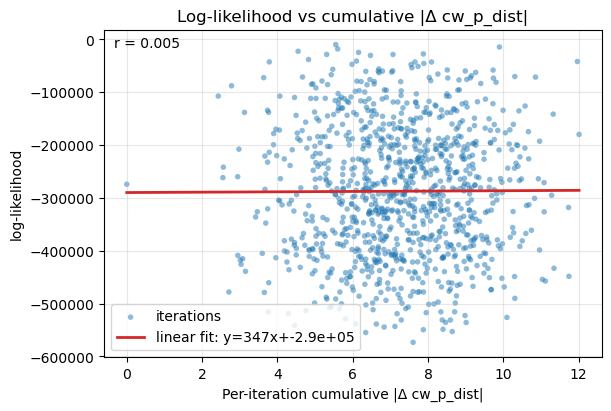

In [436]:
# Log-likelihood vs per-iteration cumulative |Δ cw_p_dist| (scatter + trend)

# Load from memory if available; otherwise from disk
try:
    res_ll = results_loglik
except NameError:
    with open('loglik_perturb_results.pkl', 'rb') as f:
        res_ll = pickle.load(f)

ll_vals = np.asarray(res_ll.get('log_likelihoods', []), dtype=float)
cumdiffs = np.asarray(res_ll.get('cumulative_diffs', []), dtype=float)

# Fallback for cumulative diffs if not present
if cumdiffs.size == 0:
    try:
        res_h = results
    except NameError:
        with open('hessian_perturb_results.pkl', 'rb') as f:
            res_h = pickle.load(f)
    cumdiffs = np.asarray(res_h.get('cumulative_diffs', []), dtype=float)

# Align lengths
n = min(ll_vals.size, cumdiffs.size)
ll_vals = ll_vals[:n]
cumdiffs = cumdiffs[:n]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
if n:
    ax.scatter(cumdiffs, ll_vals, s=16, alpha=0.5, color='C0', edgecolor='none', label='iterations')

    # Linear trend
    try:
        m, b = np.polyfit(cumdiffs, ll_vals, 1)
        xf = np.linspace(cumdiffs.min(), cumdiffs.max(), 100)
        ax.plot(xf, m * xf + b, color='C3', lw=2, label=f'linear fit: y={m:.3g}x+{b:.3g}')
    except Exception:
        pass

    # Correlation
    try:
        r = float(np.corrcoef(cumdiffs, ll_vals)[0, 1])
        ax.text(0.02, 0.98, f'r = {r:.3f}', transform=ax.transAxes, va='top')
    except Exception:
        pass

    ax.set_xlabel('Per-iteration cumulative |Δ cw_p_dist|')
    ax.set_ylabel('log-likelihood')
    ax.set_title('Log-likelihood vs cumulative |Δ cw_p_dist|')
    ax.grid(True, alpha=0.3)
    ax.legend()
else:
    ax.text(0.5, 0.5, 'No data to plot', ha='center', va='center')
    ax.axis('off')

plt.show()


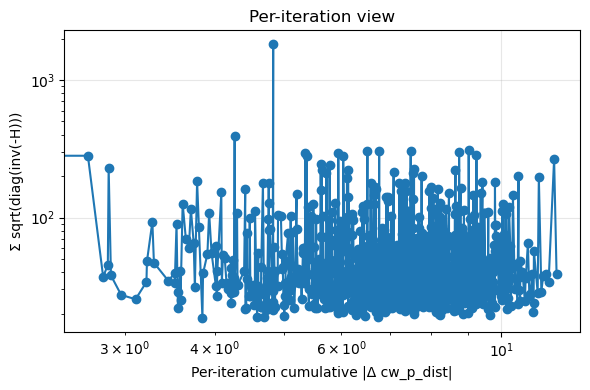

In [437]:
# Plot: sum sqrt(diag(inv(-H))) vs cw_p_dist perturbations (per-iteration only)
import pickle
import numpy as np
import matplotlib.pyplot as plt


def sum_sqrt_diag_inv_neg_hessian(H: np.ndarray) -> float:
    """Compute sum(sqrt(abs(diag(inv(-H))))) safely.
    Falls back to pseudo-inverse if -H is singular or ill-conditioned."""
    M = -np.array(H, dtype=float)
    try:
        cov = np.linalg.inv(M)
    except np.linalg.LinAlgError:
        cov = np.linalg.pinv(M)
    d = np.diag(cov)
    # Numerical safety: abs before sqrt
    return float(np.sum(np.sqrt(np.abs(d))))

# Load results from memory if available, otherwise from disk
outpath = 'hessian_perturb_results.pkl'
res = globals().get('results')
if res is None:
    with open(outpath, 'rb') as f:
        res = pickle.load(f)

hessians = [np.asarray(h, dtype=float) for h in res.get('hessians', [])]
if len(hessians) == 0:
    raise RuntimeError("No Hessians found in results; run the perturbation cell first.")

# Per-iteration cumulative |Δ| for cw_p_dist
cumdiffs = np.asarray(res.get('cumulative_diffs', []), dtype=float)

# Compute the requested metric for each Hessian
metric = np.array([sum_sqrt_diag_inv_neg_hessian(H) for H in hessians], dtype=float)

# Single-panel plot: per-iteration view (sorted by per-iteration cumulative |Δ|)
plt.figure(figsize=(6, 4))
if cumdiffs.size == metric.size and cumdiffs.size > 0:
    idx = np.argsort(cumdiffs)
    plt.plot(cumdiffs[idx], metric[idx], 'o-', color='tab:blue')
    plt.xlabel('Per-iteration cumulative |Δ cw_p_dist|')
    plt.ylabel('Σ sqrt(diag(inv(-H)))')
    plt.title('Per-iteration view')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Per-iteration data unavailable', ha='center', va='center')
    plt.gca().axis('off')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
plt.show()


In [438]:
hessians

[array([[-1.34848623e+10,  5.29103839e+05,  1.30008111e+06, ...,
         -2.49828841e+07, -1.23609450e+10,  3.81588101e+09],
        [ 5.29103839e+05,  1.36254766e+01,  4.70039946e+01, ...,
          2.80604740e+02,  4.84770199e+05, -1.49839939e+05],
        [ 1.30008111e+06,  4.70039946e+01,  1.53741523e+02, ...,
          6.93058498e+02,  1.19114793e+06, -3.68176642e+05],
        ...,
        [-2.49828841e+07,  2.80604740e+02,  6.93058498e+02, ...,
          1.12287728e+06,  4.43496618e+09, -1.75436537e+09],
        [-1.23609450e+10,  4.84770199e+05,  1.19114793e+06, ...,
          4.43496618e+09,  1.12649102e+13, -5.45560524e+12],
        [ 3.81588101e+09, -1.49839939e+05, -3.68176642e+05, ...,
         -1.75436537e+09, -5.45560524e+12,  2.28509851e+12]],
       shape=(39, 39)),
 array([[-1.85646697e+10, -1.12945599e+05, -1.99226875e+05, ...,
         -7.08316679e+06, -2.33863045e+10,  7.23033049e+09],
        [-1.12945599e+05, -1.54040334e+01, -3.13246560e+01, ...,
         -2.523

In [439]:
for h in hessians:
    print(jnp.sum(jnp.sqrt(jnp.diagonal(jnp.linalg.inv(-h)))))

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [440]:
jnp.diagonal(jnp.linalg.inv(-h))

Array([ 3.05641958e-09,  2.21307358e-01,  1.57906448e-02,  2.77010187e-09,
        2.00207910e-04, -5.12290562e-05,  1.31329461e-07,  4.28460266e-02,
       -6.76250575e-05,  1.42346501e-08, -1.14713253e-02, -7.19404439e-04,
        3.62678099e-11, -1.00184559e-02, -7.58565943e-04, -1.53037270e-08,
       -6.87787829e-01, -5.08056860e-02,  1.38863665e-07, -5.25501856e-01,
       -1.50972981e-01,  2.52313394e-09, -2.36721858e+02, -1.78940547e+01,
       -7.84460097e-11,  5.36280678e-02,  2.69200819e-03, -3.34009483e-08,
       -9.92158711e+00, -1.83676897e+00, -2.99521771e-01, -5.55608790e-02,
        3.27486602e-07,  1.22978108e-10, -6.09829475e-08, -1.23927337e-05,
        1.01951322e-07, -4.67184170e-10, -1.10972120e-09], dtype=float64)

In [442]:
fml.logL.params

['B1855+09_cw_p_dist',
 'B1855+09_rednoise_gamma',
 'B1855+09_rednoise_log10_A',
 'B1937+21_cw_p_dist',
 'B1937+21_rednoise_gamma',
 'B1937+21_rednoise_log10_A',
 'B1953+29_cw_p_dist',
 'B1953+29_rednoise_gamma',
 'B1953+29_rednoise_log10_A',
 'J0023+0923_cw_p_dist',
 'J0023+0923_rednoise_gamma',
 'J0023+0923_rednoise_log10_A',
 'J0030+0451_cw_p_dist',
 'J0030+0451_rednoise_gamma',
 'J0030+0451_rednoise_log10_A',
 'J0125-2327_cw_p_dist',
 'J0125-2327_rednoise_gamma',
 'J0125-2327_rednoise_log10_A',
 'J0340+4130_cw_p_dist',
 'J0340+4130_rednoise_gamma',
 'J0340+4130_rednoise_log10_A',
 'J0406+3039_cw_p_dist',
 'J0406+3039_rednoise_gamma',
 'J0406+3039_rednoise_log10_A',
 'J0437-4715_cw_p_dist',
 'J0437-4715_rednoise_gamma',
 'J0437-4715_rednoise_log10_A',
 'J0509+0856_cw_p_dist',
 'J0509+0856_rednoise_gamma',
 'J0509+0856_rednoise_log10_A',
 'crn_gamma',
 'crn_log10_A',
 'cw_cosinc',
 'cw_log10_f0',
 'cw_log10_h0',
 'cw_phi_earth',
 'cw_psi',
 'cw_ra',
 'cw_sindec']